In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import img_pross_help as imgh
import tf_helper_funcs as tf_help

In [2]:
def vect_to_num(v):
    pwr = len(v)-1
    num = 0
    
    for i in range(len(v)):
        num+=v[i]*(2**pwr)
        pwr-=1
    return num
def one_hot_(v):
    ans = len(v)
    for val in v:
        if val is 1:
            return ans
        else:
            ans -=1
def extract_classnum(vect,keyref):
    outp = []
    for v in vect:
        for cat, v in keyref.items():
            outp.append(str(v) + " " + str(cat))
    return outp


In [3]:
# Dictionary for Image Encoding
key_dict = {
    'laptop':[0,0,0,1],
    'cup':[0,0,1,0],
    'chair':[0,1,0,0],
    'car':[1,0,0,0]
}
translate_dict = {
    4:'Failed Prediction Class',
    3:'Category: 1 Name: laptop',
    2:'Category: 2 Name: cup',
    1:'Category: 3 Name: chair',
    0:'Category: 4 Name: car'
}
# Data Pre-process
img_wh = 64 # Image Width and Height
img_flat = img_wh**2 # The size of the image flattened
img_shape = (img_wh,img_wh) # Holds the dimension of the image
color_channels = 3 # RGB is a 3 color channel
num_classes = 4 # 4 Total number of classification possibilities
#imgh.PrepImages("images/all_source_images","images/train_imgs", "images/test_imgs",img_wh,img_wh,0.7) #Only needs to be ran initially

In [4]:
train_Images,train_Labels = imgh.ImportImages("images/train_imgs",key_dict) # Extract Training Images and Labels
test_Images,test_Labels = imgh.ImportImages("images/test_imgs",key_dict)# Extract Testing Images and Labels

#train_Images = imgh.shape_up_X(train_Images,img_wh,color_channels,train_Labels.shape[0])
#test_Images = imgh.shape_up_X(test_Images,img_wh,color_channels,test_Labels.shape[0])

print("Training Label Shape: ",train_Labels.shape)
print("Training Images Shape:",train_Images.shape)
print(" ")
print("Testing Label Shape: ",test_Labels.shape)
print("Testing Images Shape:",test_Images.shape)
# Randomize Data
for i in range(10):
    r = np.random.permutation(range(len(test_Labels)))
    
    test_Labels = test_Labels[r,:]
    test_Images = test_Images[r,:]

Training Label Shape:  (227, 4)
Training Images Shape: (227, 64, 64, 3)
 
Testing Label Shape:  (96, 4)
Testing Images Shape: (96, 64, 64, 3)


In [5]:
print("Training Label Example: ")
train_Labels[0:10]

Training Label Example: 


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

### Model Overview:
An initial convolutional layer of size 28x28x10 and a filter size of 5x5 which will then go through a convolutional layer of size 14x14x15 with a filter size of 3 and using max pooling.

A fully connected layer will then flatten out the resulting convlutional outputs.


In [6]:
X = tf.placeholder(tf.float32, shape=[None,img_wh, img_wh, color_channels]) # X Input Site
x_image = tf.reshape(X, [-1, img_wh, img_wh, color_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_classes]) # Class Output Variable

In [7]:
# Create First Convolutional Layer

CONV_L1 = tf_help.new_conv2d_layer(x_image,64,6)

# Create Second Convolutional Layer

CONV_L2= tf_help.new_conv2d_layer(CONV_L1,32,3)

# Create Third Convolutional Layer with Pooling

CONV_L3= tf_help.new_conv2d_layer(CONV_L2,20,3)

# Pooling Layer After Third Convolutional Layer
POOL_L3 = tf_help.new_max_pool(CONV_L3,10)

# First Fully Connected Layer 
conv3_, conv3_len = tf_help.flatten_layer(POOL_L3)
FC_L1 = tf.layers.dense(inputs= conv3_, units= conv3_len, activation = tf.nn.relu)

# Second Fully Connected Layer
FC_L2 = tf.layers.dense(inputs=FC_L1, units=num_classes)


In [8]:
CONV_L1

<tf.Tensor 'conv2d/Relu:0' shape=(?, 64, 64, 64) dtype=float32>

In [9]:
CONV_L2

<tf.Tensor 'conv2d_2/Relu:0' shape=(?, 64, 64, 32) dtype=float32>

In [10]:
CONV_L3

<tf.Tensor 'conv2d_3/Relu:0' shape=(?, 64, 64, 20) dtype=float32>

In [11]:
POOL_L3

<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 28, 28, 20) dtype=float32>

In [12]:
FC_L1

<tf.Tensor 'dense/Relu:0' shape=(?, 15680) dtype=float32>

In [13]:
FC_L2

<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 4) dtype=float32>

In [14]:
                                # Build and Connect Model
# Y
y_out =tf.nn.softmax(FC_L2) # Prototype Y output vector
#y_class = tf.argmax(y_out,axis=1) # Keep Largest Element of Vector
y_class = tf.argmax(y_out,1)

# Cost Function
cost = tf.nn.softmax_cross_entropy_with_logits(logits = FC_L2, labels = Y)
cost_fun = tf.reduce_mean(cost)

# Cost Optimization
#optimize_fun = tf.train.GradientDescentOptimizer(0.05).minimize(cost_fun)
optimize_fun = tf.train.AdamOptimizer(learning_rate=1e-5, beta1=0.9, beta2=0.999, epsilon=1e-07).minimize(cost_fun)

# Accuracy Measurements
correct_ =  tf.equal(tf.cast(y_out, tf.float32), Y)
accuracy = tf.reduce_mean(tf.cast(correct_, tf.float32))

In [15]:
# Init Session
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
# Define Batch Size for Train Step
batch_size = 8
j_old = 0

In [16]:
                                # Training Step
for i in range(2):
    # Randomize the Order of Training Labels 
    r = np.random.permutation(range(len(train_Labels)))
    train_Labels = train_Labels[r,:]
    train_Images = train_Images[r,:]
    for itr in range(100):
        j_old = 0
        #print("Iteration: ",itr)
        if(itr % 10 is 0):
            r = np.random.permutation(range(int(len(test_Labels)/3)))
            accr = accuracy.eval(feed_dict = {X:test_Images[r], Y:test_Labels[r]})
            print("Round: " + str(i) + " At Iteration: " + str(itr) + " Accuracy: "+'{:.2%}'.format(accr))
        # Loop to Batch Train
        for j in range(batch_size,len(train_Images),batch_size):
            session.run(optimize_fun,feed_dict = {X:train_Images[j_old:j], Y:train_Labels[j_old:j]})
            j_old = j

Round: 0 At Iteration: 0 Accuracy: 0.00%
Round: 0 At Iteration: 10 Accuracy: 39.84%
Round: 0 At Iteration: 20 Accuracy: 46.88%
Round: 0 At Iteration: 30 Accuracy: 49.22%
Round: 0 At Iteration: 40 Accuracy: 53.12%
Round: 0 At Iteration: 50 Accuracy: 53.12%
Round: 0 At Iteration: 60 Accuracy: 53.12%
Round: 0 At Iteration: 70 Accuracy: 53.12%
Round: 0 At Iteration: 80 Accuracy: 53.12%
Round: 0 At Iteration: 90 Accuracy: 53.12%
Round: 1 At Iteration: 0 Accuracy: 52.34%
Round: 1 At Iteration: 10 Accuracy: 52.34%
Round: 1 At Iteration: 20 Accuracy: 52.34%
Round: 1 At Iteration: 30 Accuracy: 52.34%
Round: 1 At Iteration: 40 Accuracy: 52.34%
Round: 1 At Iteration: 50 Accuracy: 52.34%
Round: 1 At Iteration: 60 Accuracy: 52.34%
Round: 1 At Iteration: 70 Accuracy: 52.34%
Round: 1 At Iteration: 80 Accuracy: 52.34%
Round: 1 At Iteration: 90 Accuracy: 52.34%


In [17]:
p = accuracy.eval(feed_dict = {X:test_Images[0:50], Y:test_Labels[0:50]})
p2 = accuracy.eval(feed_dict = {X:test_Images[50:100], Y:test_Labels[50:100]})
test = session.run(y_class,feed_dict = {X:test_Images[0:50], Y:test_Labels[0:50]})
print("Accuracy: ")
avg = (p+p2)/2
print( '{:.2%}'.format(avg))
print()
print("Results: ")
#test = np.argmax(test) 
print(test)
print()
print("True Labels: ")
print(np.argmax(test_Labels[0]))
#print("One Hot Val: ", np.argmax(test_Labels[0]))
for i in range(0,50):
    print("At Index: %d"%(i))
    #print("Actual Class: " + str(translate_dict[vect_to_num(test_Labels[i])]) + " ---- Predicted Class:  " + str(translate_dict[vect_to_num(test[i].astype(np.int))]))
    #print("Actual Class: " + str(translate_dict[one_hot_to_num(test_Labels[i])]) + " ---- Predicted Class:  " + str(translate_dict[one_hot_to_num(test[i])]))
    print("Predicted: %s --> Actual: %s"%(translate_dict[(test[i])],translate_dict[np.argmax(test_Labels[i])]))

Accuracy: 
51.18%

Results: 
[0 3 0 0 1 0 0 0 0 1 0 3 2 2 2 1 1 1 1 0 0 1 1 2 0 0 0 1 1 2 0 3 3 0 0 2 3
 0 0 1 3 2 1 0 1 0 0 1 2 0]

True Labels: 
3
At Index: 0
Predicted: Category: 4 Name: car --> Actual: Category: 1 Name: laptop
At Index: 1
Predicted: Category: 1 Name: laptop --> Actual: Category: 1 Name: laptop
At Index: 2
Predicted: Category: 4 Name: car --> Actual: Category: 4 Name: car
At Index: 3
Predicted: Category: 4 Name: car --> Actual: Category: 4 Name: car
At Index: 4
Predicted: Category: 3 Name: chair --> Actual: Category: 3 Name: chair
At Index: 5
Predicted: Category: 4 Name: car --> Actual: Category: 4 Name: car
At Index: 6
Predicted: Category: 4 Name: car --> Actual: Category: 4 Name: car
At Index: 7
Predicted: Category: 4 Name: car --> Actual: Category: 4 Name: car
At Index: 8
Predicted: Category: 4 Name: car --> Actual: Category: 4 Name: car
At Index: 9
Predicted: Category: 3 Name: chair --> Actual: Category: 4 Name: car
At Index: 10
Predicted: Category: 4 Name: car 

Category: 3 Name: chair


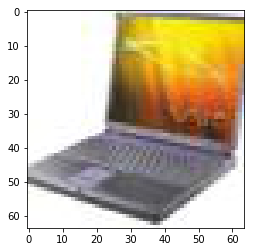

In [20]:
ref_index = 21
img = test_Images[ref_index]

plt.imshow(img.astype(np.uint8))
print(translate_dict[(test[ref_index])])
#test_Images.shape
#test_Images[0,:,:,0]